# Analyzing  Vektis open data
This jupyter Notebook used some of the open data from Vektis (https://www.vektis.nl/intelligence/open-data).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

Set the parameters

In [2]:
# When True, the code will try to connect to the data-files through http.
# When False, make sure to download the files to the 'data' folder
online = True

# When True, the code will save a few of the acquired DataFrames to csv for further analysis in e.g. Excel
export = True

analysejaar = '2011'
analysegemeente = 'GOUDA'
analysenaam = 'KOSTEN_FARMACIE'
analysekolom = analysenaam + ' per AANTAL_VERZEKERDEJAREN'

#KOSTEN_FARMACIE,KOSTEN_MEDISCH_SPECIALISTISCHE_ZORG,KOSTEN_HUISARTS_CONSULT,KOSTEN_HULPMIDDELEN,KOSTEN_MONDZORG,
#KOSTEN_PARAMEDISCHE_ZORG_FYSIOTHERAPIE,KOSTEN_KRAAMZORG,KOSTEN_VERLOSKUNDIGE_ZORG

Let's import the information about municipalities.

In [3]:
def importVektisDataMunicipalities (online, yearAnalysis, nameAnalysis, chunksize):
    """import the correct CSV file for municipalities and return a pandas DataFrame. Just keeps information about 
    the name of the municipality, gender, age-categories and number of insured years (as an alternative measure 
    for the number of people.
    
    Parameters:
        online (boolean): determines whether the file should be read from the website of Vektis or from the data-subfolder
        year (str): determines which year needs to be imported
        nameAnalysis (str): determines which column will be imported (and later analysed)
        chunksize (int): chunksize for processing the CSV file

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    if online:
        url = 'https://www.vektis.nl/uploads/Docs%20per%20pagina/Open%20Data%20Bestanden/Oud/OpenData%20' + yearAnalysis + '%20gem-5jcat.csv'
    else:
        url = 'OpenData ' + yearAnalysis + ' gem-5jcat.csv'

    #create empty DataFrame
    df_ret = pd.DataFrame()

    #create reader for chunk-wise reading of large .csv
    reader = pd.read_csv(url, sep=';', header=0, chunksize=chunksize, skiprows=[1])

    #only keep relevant information
    for chunk in reader:
        chunk = chunk[['GEMEENTENAAM','GESLACHT','LEEFTIJDSKLASSE',nameAnalysis,'AANTAL_VERZEKERDEJAREN']]
        df_ret = df_ret.append(chunk)

    return df_ret

df = importVektisDataMunicipalities(online, analysejaar, analysenaam, 10000)
df.head()

,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE,AANTAL_VERZEKERDEJAREN
0,AA EN HUNZE,M,0 t/m 4 jaar,35758.49,504.91
1,AALBURG,M,0 t/m 4 jaar,56840.29,401.76
2,AALSMEER,M,0 t/m 4 jaar,81961.73,946.30
3,AALTEN,M,0 t/m 4 jaar,83090.93,709.39
4,ACHTKARSPELEN,M,0 t/m 4 jaar,93637.55,814.69


df_analysis1 contains information about the selected municipality.

In [4]:
def processMunicipality (df, municipalityAnalysis, nameAnalysis):
    """Processes the dataframe. Selects the indicated municipality, calculates the indicated column per insured year (as an
    alternative measure for the number of people), and strips the original two columns needed for that calculation.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        municipalityAnalysis: the name for the selected municipality
        nameAnalysis (str): determines which column will be imported (and later analysed)

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    df[analysekolom] = df[nameAnalysis] / df['AANTAL_VERZEKERDEJAREN']
    df_ret = df.loc[df['GEMEENTENAAM'] == municipalityAnalysis, ['GEMEENTENAAM','GESLACHT','LEEFTIJDSKLASSE',analysekolom]]
    df.drop(analysekolom, axis=1)
    
    return df_ret

df_analysis1 = processMunicipality(df, analysegemeente, analysenaam)
df_analysis1.head()

,GEMEENTENAAM,GESLACHT,LEEFTIJDSKLASSE,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
117,GOUDA,M,0 t/m 4 jaar,154.285970
497,GOUDA,M,5 t/m 9 jaar,132.732602
877,GOUDA,M,10 t/m 14 jaar,87.632715
1257,GOUDA,M,15 t/m 19 jaar,75.667721
1637,GOUDA,M,20 t/m 24 jaar,77.566478


df_analysis3 contains the analysed value per municipality

In [5]:
def calculateCountryAveragePerMunicipality(df, nameAnalysis):
    """Processes the dataframe. Calculates the indicated column per insured year (as an alternative measure for the number
    of people), and strips the original two columns needed for that calculation.
    
    Parameters:
        df (dataframe): the dataframe containing the 'raw' data (from importVektisDataMunicipality)
        nameAnalysis (str): determines which column will be imported (and later analysed)

    Returns:
    dataframe:the pandas DataFrame containing the requested information
    """
    df_ret = df.pivot_table(index=['GEMEENTENAAM'], values=[nameAnalysis,'AANTAL_VERZEKERDEJAREN'], aggfunc=sum)
    df_ret[analysekolom] = df_ret[nameAnalysis] / df_ret['AANTAL_VERZEKERDEJAREN']
    df_ret = df_ret.drop(['AANTAL_VERZEKERDEJAREN',nameAnalysis], axis=1)

    return df_ret

df_analysis3 = calculateCountryAveragePerMunicipality(df, analysenaam)
df_analysis3.head()

,KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM,
AA EN HUNZE,287.005052
AALBURG,292.127145
AALSMEER,287.562614
AALTEN,305.770968
ACHTKARSPELEN,292.294500


Let's do some graphical inspection of the averages around the country

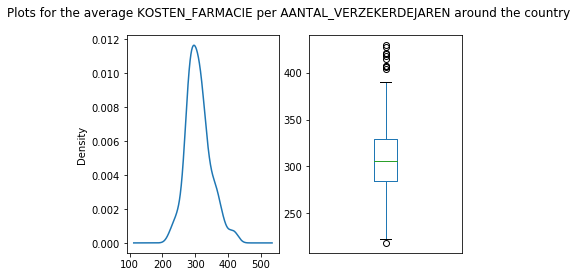

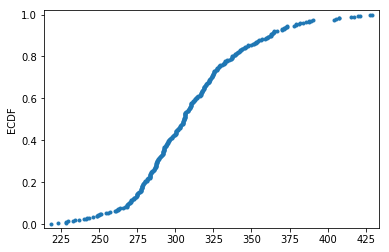

In [6]:
def ecdf(data):
    """Compute ECDF (Empirical cumulative distribution function) for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

def plotSpreads(df, nameAnalysis):
    """Plots three different plots for the provide (single column) Dataframe: (1) the PDF (Probability Density Function, (2) the boxplot
    , and (3) the ECDF (Empirical cumulative distribution function)

    Parameters:
        df (dataframe): the dataframe containing the single column dataframe
        nameAnalysis (str): used for showing the proper title
    """
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Plots for the average ' + nameAnalysis + ' per AANTAL_VERZEKERDEJAREN around the country')
    #Probability Density Functions (PDF)
    _ = df.plot.kde(ax=axes[0])
    #Box plot
    _ = df.plot(ax=axes[1], kind='box')
    _ = axes[1].set_xticks([])

    plt.show()

    x,y = ecdf(df)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.ylabel('ECDF')
    _ = plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
plotSpreads(df_analysis3[analysekolom], analysenaam)

df_analysis2_m and df_analysis2_v contain information required for a box plot of the average values within the country

In [68]:
def prepareBoxplotData(df, nameAnalysis):
    """ToDo
    """
    df[analysekolom] = df[nameAnalysis] / df['AANTAL_VERZEKERDEJAREN']
    df_ret = df[['GESLACHT','LEEFTIJDSKLASSE','GEMEENTENAAM',analysekolom]].pivot_table(index=['GEMEENTENAAM'], columns=['GESLACHT','LEEFTIJDSKLASSE'], values=[analysekolom], aggfunc=sum, fill_value=0)
    df.drop(analysekolom, axis=1)

    df_ret.columns = df_ret.columns.droplevel(0)
    df_ret.reset_index(inplace=True)
    
    df_ret_m = df_ret.loc[:,['M']]
    df_ret_m.columns = df_ret_m.columns.droplevel(0)
    df_ret_m.index.astype(str)
    
    df_ret_v = df_ret.loc[:,['V']]
    df_ret_v.columns = df_ret_v.columns.droplevel(0)
    df_ret_v.index.astype(str)
    
    return df_ret_m, df_ret_v

df_analysis2_m, df_analysis2_v = prepareBoxplotData(df, analysenaam)
df_analysis2_v.head()

LEEFTIJDSKLASSE,0 t/m 4 jaar,5 t/m 9 jaar,10 t/m 14 jaar,15 t/m 19 jaar,20 t/m 24 jaar,25 t/m 29 jaar,30 t/m 34 jaar,35 t/m 39 jaar,40 t/m 44 jaar,45 t/m 49 jaar,50 t/m 54 jaar,55 t/m 59 jaar,60 t/m 64 jaar,65 t/m 69 jaar,70 t/m 74 jaar,75 t/m 79 jaar,80 t/m 84 jaar,85 t/m 89 jaar,90+
0,41.217136,32.604490,50.767868,81.613035,97.181391,222.403606,176.086972,174.963839,197.126347,207.638761,269.044957,379.954416,380.105556,455.161080,620.520956,686.477829,821.181842,991.858255,918.730312
1,93.861171,25.486329,53.283046,111.020330,140.083413,147.048103,194.886834,372.175598,255.465042,321.461574,444.600049,484.509977,422.218598,608.026840,884.931668,897.617193,1041.952297,1157.385857,884.664938
2,68.414412,49.691253,46.192535,158.512497,142.903874,118.890232,166.429435,210.741929,264.821905,227.060757,393.146127,424.087407,489.277184,484.109801,613.059809,759.396456,1039.071088,998.967574,1379.338474
3,70.819324,35.772282,69.903949,126.131371,164.728189,149.715279,222.837038,142.343212,224.334792,310.083865,316.166037,492.900582,467.011675,788.005468,668.159690,739.486573,824.811500,878.001075,844.601637
4,56.635540,53.808314,57.194877,76.714331,93.272347,139.181372,252.176844,192.609638,304.994621,321.376953,357.254017,425.414921,511.060857,673.869980,683.106462,834.414878,1046.778931,911.766733,1076.553966


In [8]:
def calculatePercentilesPerGenderandAgeCategory(df, nameAnalysis):
    """Calculates the 2.5%, 50% en 97.5% percentiles for the indicated column per insured year (as an alternative 
    measure for the number of people) per gender and age category.
    """
    df[analysekolom] = df[nameAnalysis] / df['AANTAL_VERZEKERDEJAREN']
    df_ret = df[['GESLACHT','LEEFTIJDSKLASSE','GEMEENTENAAM',analysekolom]].pivot_table(index=['GESLACHT','LEEFTIJDSKLASSE'], columns='GEMEENTENAAM', values=[analysekolom], aggfunc=sum)
    df.drop(analysekolom, axis=1)
    mean  = df_ret.mean(skipna=True,  axis=1)
    p2_5  = df_ret.quantile(2.5/100,  axis=1)
    p50   = df_ret.quantile(50/100,   axis=1)
    p97_5 = df_ret.quantile(97.5/100, axis=1)
    df_ret['mean']  = mean
    df_ret['p2_5']  = p2_5
    df_ret['p50']   = p50
    df_ret['p97_5'] = p97_5

    df_ret.columns = df_ret.columns.droplevel(1)
    df_ret = df_ret[['mean','p2_5','p50','p97_5']]
    df_ret.reset_index(inplace=True)
    
    return df_ret

df_analysis6 = calculatePercentilesPerGenderandAgeCategory(df, analysenaam)
df_analysis6.head()

,GESLACHT,LEEFTIJDSKLASSE,mean,p2_5,p50,p97_5
0,M,0 t/m 4 jaar,100.969622,49.125370,95.793598,174.253581
1,M,5 t/m 9 jaar,68.265813,32.096645,63.442707,135.110351
2,M,10 t/m 14 jaar,88.664088,37.629368,82.804757,169.765611
3,M,15 t/m 19 jaar,86.925215,42.595176,78.458083,195.963555
4,M,20 t/m 24 jaar,82.295045,39.469429,74.383611,150.826852


Let's find out which municipalities are outside the 95% confidence interval...

In [9]:
p2_5, p97_5 = np.percentile(df_analysis3,[2.5,97.5])
print( df_analysis3[ df_analysis3[analysekolom] < p2_5 ].sort_values(analysekolom) )
print( df_analysis3[ df_analysis3[analysekolom] > p97_5 ].sort_values(analysekolom, ascending=False) )

if export:
    df_analysis1.to_csv('data/df_vektis_demography_' + analysejaar + '_' + analysegemeente + '.csv', decimal=',', index=True)
    df_analysis3.to_csv('data/df_vektis_' + analysejaar + '.csv', decimal=',', index=True)
    df_analysis3[ df_analysis3[analysekolom] < p2_5 ].append(df_analysis3[ df_analysis3[analysekolom] > p97_5 ]).reset_index().to_csv('data/outliers_' + analysejaar + '.csv', decimal=',', index=False)
    df_analysis6.to_csv('data/df_vektis_percentiles' + analysejaar + '.csv', decimal=',', index=True)

                KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM                                              
KOGGENLAND                                      217.931194
FERWERDERADIEL                                  222.599728
URK                                             228.091221
LANGEDIJK                                       228.096013
RENSWOUDE                                       229.172824
DRECHTERLAND                                    232.435111
STAPHORST                                       234.160164
BEEMSTER                                        236.439071
ZEEWOLDE                                        239.959192
AMELAND                                         241.135721
                KOSTEN_FARMACIE per AANTAL_VERZEKERDEJAREN
GEMEENTENAAM                                              
VAALS                                           429.475513
MEERSSEN                                        427.875421
HEERLEN                                         421.6286

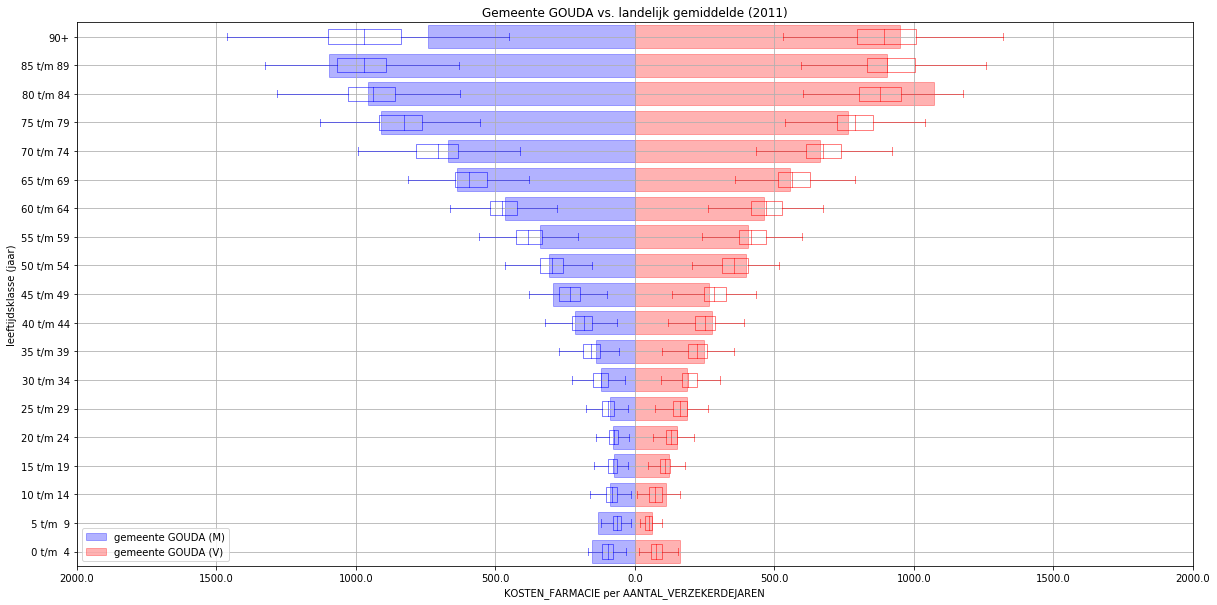

In [92]:
def draw_boxplot(ax, data, edge_color, fill_color, alpha=1, showfliers=True):
    '''shows boxplots of data along the ax axis'''
    #flierprops = dict(marker='o', markerfacecolor='r', markersize=12,linestyle='none', markeredgecolor='g')

    #bp_dict = data.boxplot(vert=False, return_type='dict', showfliers=showfliers) #pandas version 
    bp_dict = ax.boxplot(data, vert=False, showfliers=showfliers)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp_dict[element], color=edge_color, alpha=alpha)
    plt.setp(bp_dict['fliers'], markeredgecolor=edge_color, markerfacecolor=fill_color)

def plotPopulationPyramid(df_municipality, df_boxplot_m, df_boxplot_v, df_percentiles, municipalityAnalysis, nameAnalysis, yearAnalysis):
    """Plot a 'population pyramid' of the country averages includingcorresponding error bars AND the values from
    the selected municipality

    Parameters:
        df_municipality (dataframe): the dataframe containing information about the selected municipality
        df_country (dataframe): the dataframe containing the information about the country averages
        df_percentiles (dataframe): the dataframe containing the information about the 2.5% and 97.5% percentiles
        municipalityAnalysis (str): used for showing the proper title and creating the proper filename for export
        nameAnalysis (str): used for showing the proper title
        yearAnalysis (str): used for showing the proper title and creating the proper filename for export
        display (boolean): True to show the plot

    """
    # X contains the list of different age-categories
    X = np.array(df_municipality[df_municipality['GESLACHT'] == 'V']['LEEFTIJDSKLASSE'])
    
    # Transfer the information to specific men / women dataframes. We make sure all age categories are used by initializing a
    # dataframe with all labels and '0' value
    df_men_pop = df_municipality[df_municipality['GESLACHT'] == 'M'].set_index('LEEFTIJDSKLASSE').sort_index()
    df_men_pop = pd.DataFrame(X).set_index(0).join(df_men_pop, how='left').fillna(0)[analysekolom]
    
    df_women_pop = df_municipality[df_municipality['GESLACHT'] == 'V'].set_index('LEEFTIJDSKLASSE').sort_index()
    df_women_pop = pd.DataFrame(X).set_index(0).join(df_women_pop, how='left').fillna(0)[analysekolom]
    
    # Convert the dataframes to a Numpy Array for plotting purposes
    men_pop   = np.array( df_men_pop.values )
    women_pop = np.array( df_women_pop.values )
    boxplot_m = np.array( df_boxplot_m.values )
    boxplot_v = np.array( df_boxplot_v.values)

    # Now, we finally plot
    fig, ax = plt.subplots(figsize=(20,10))

    _ = plt.title('Gemeente ' + municipalityAnalysis + ' vs. landelijk gemiddelde (' + yearAnalysis + ')')
    _ = plt.xlabel(analysekolom)
    _ = plt.ylabel('leeftijdsklasse (jaar)')
    
    _ = ax.barh(range(1,len(men_pop)+1), -men_pop, color = 'b', edgecolor='b', height=0.8, alpha=0.3, label='gemeente ' + municipalityAnalysis + ' (M)')
    _ = ax.barh(range(1,len(women_pop)+1), women_pop, color = 'r', edgecolor='r', height=0.8, alpha=0.3, label='gemeente ' + municipalityAnalysis + ' (V)')
    _ = plt.legend(loc='lower left')
    
    draw_boxplot(ax, -boxplot_m, 'b', 'b', alpha=0.5, showfliers=False)
    draw_boxplot(ax, boxplot_v, 'r', 'r', alpha=0.5, showfliers=False)
    
    _ = ax.set_yticklabels([' 0 t/m  4', ' 5 t/m  9', '10 t/m 14', '15 t/m 19', '20 t/m 24', '25 t/m 29', '30 t/m 34', '35 t/m 39', '40 t/m 44', '45 t/m 49', '50 t/m 54', '55 t/m 59', '60 t/m 64', '65 t/m 69', '70 t/m 74', '75 t/m 79', '80 t/m 84', '85 t/m 89', '90+'])
    
    if nameAnalysis == 'KOSTEN_FARMACIE':
        _ = ax.set_xlim(-2000,2000)

    xlocs, xlabs = plt.xticks()
    _ = plt.xticks(xlocs, np.absolute(xlocs))
    _ = ax.xaxis.grid()
    _ = ax.yaxis.grid()

    if export:
        plt.savefig('data/' + municipalityAnalysis + '_' + nameAnalysis + '_' + yearAnalysis + '.png')
    plt.show()
    
plotPopulationPyramid(df_analysis1, df_analysis2_m, df_analysis2_v, df_analysis6, analysegemeente, analysenaam, analysejaar)

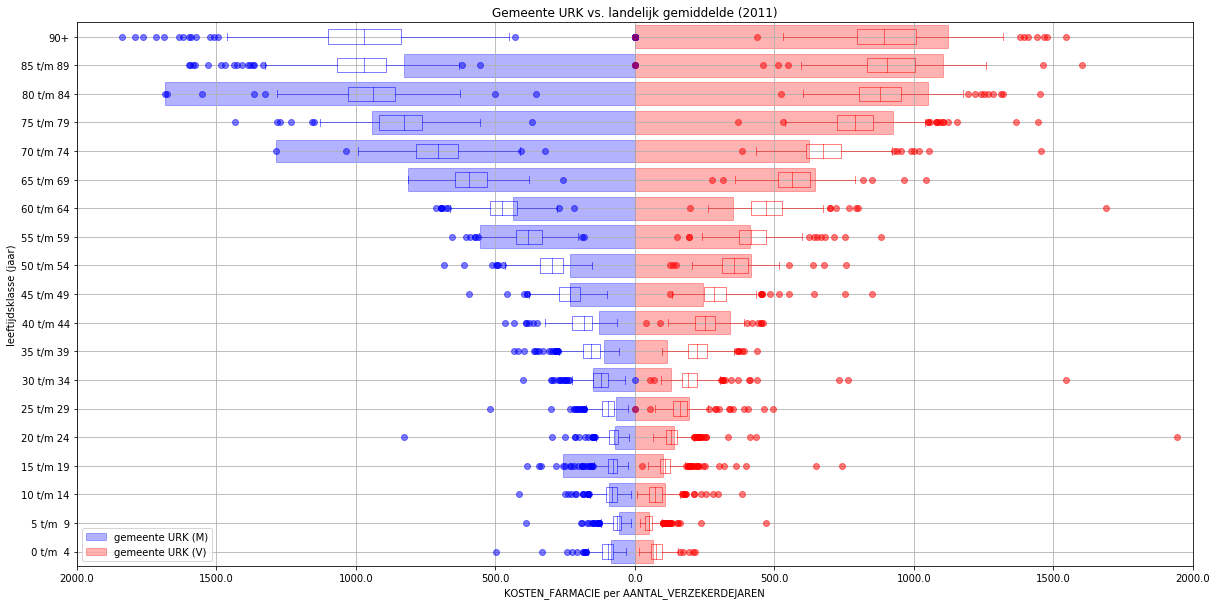

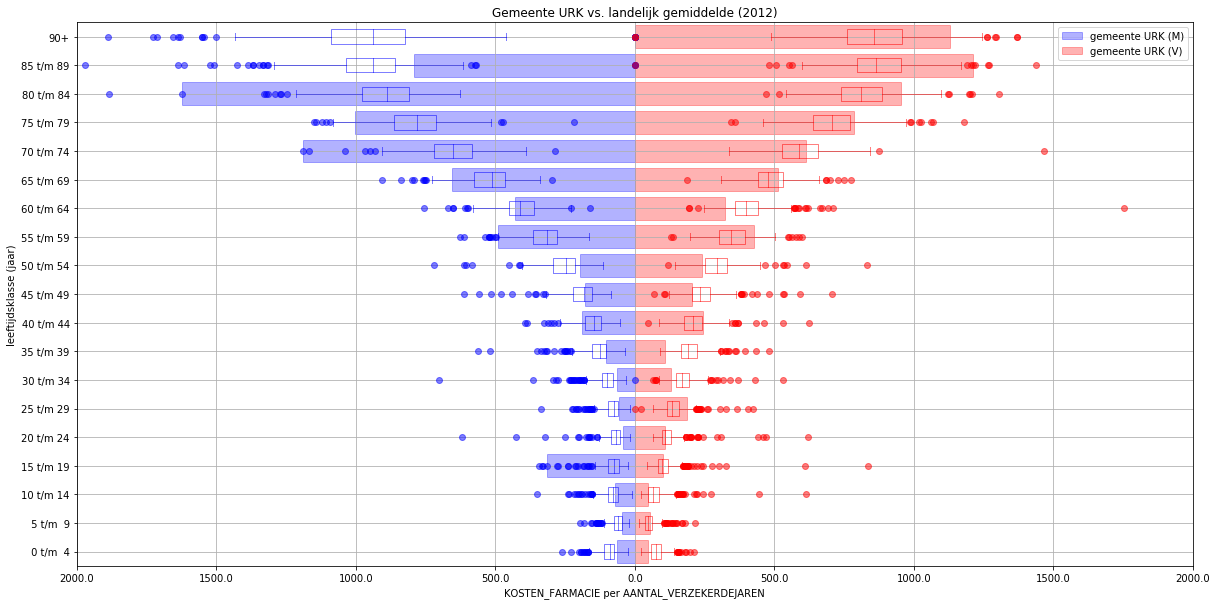

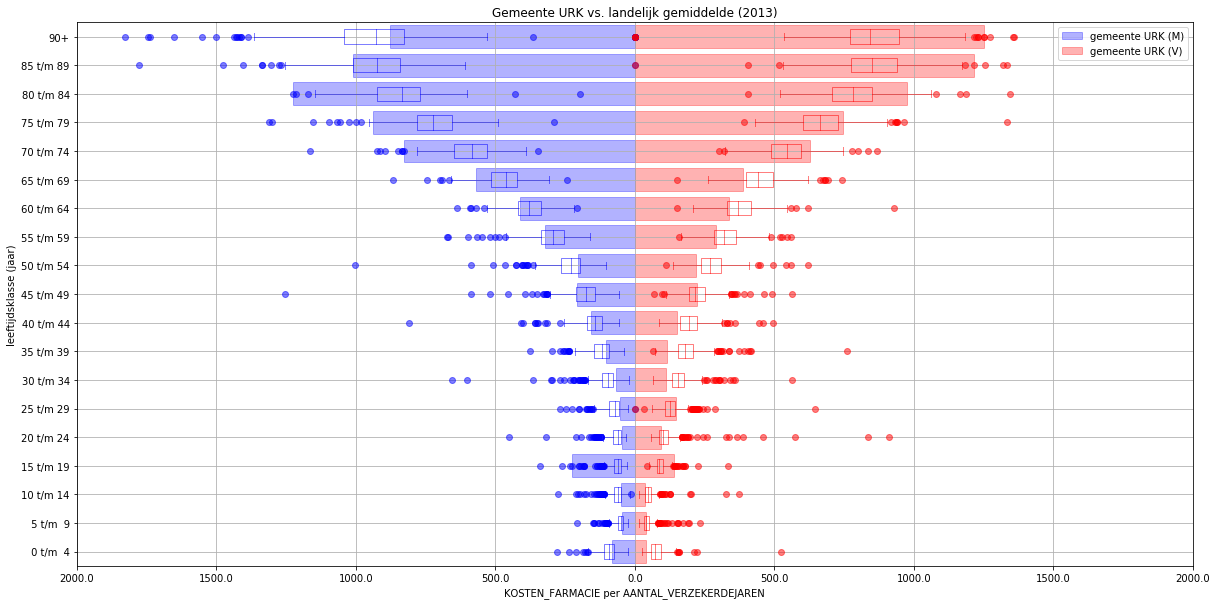

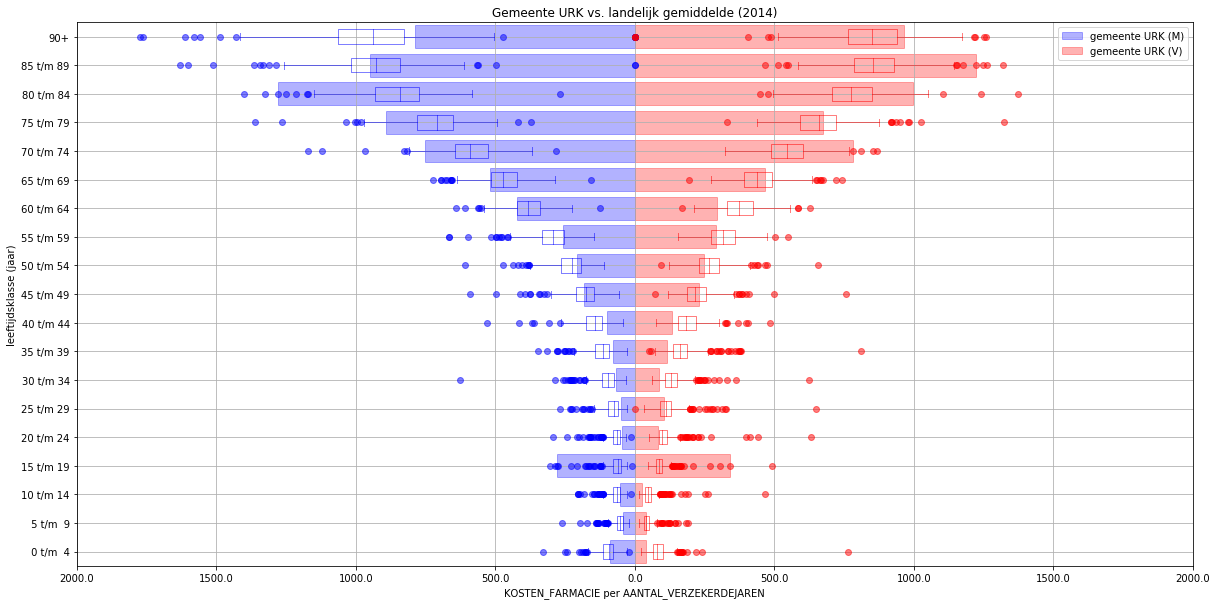

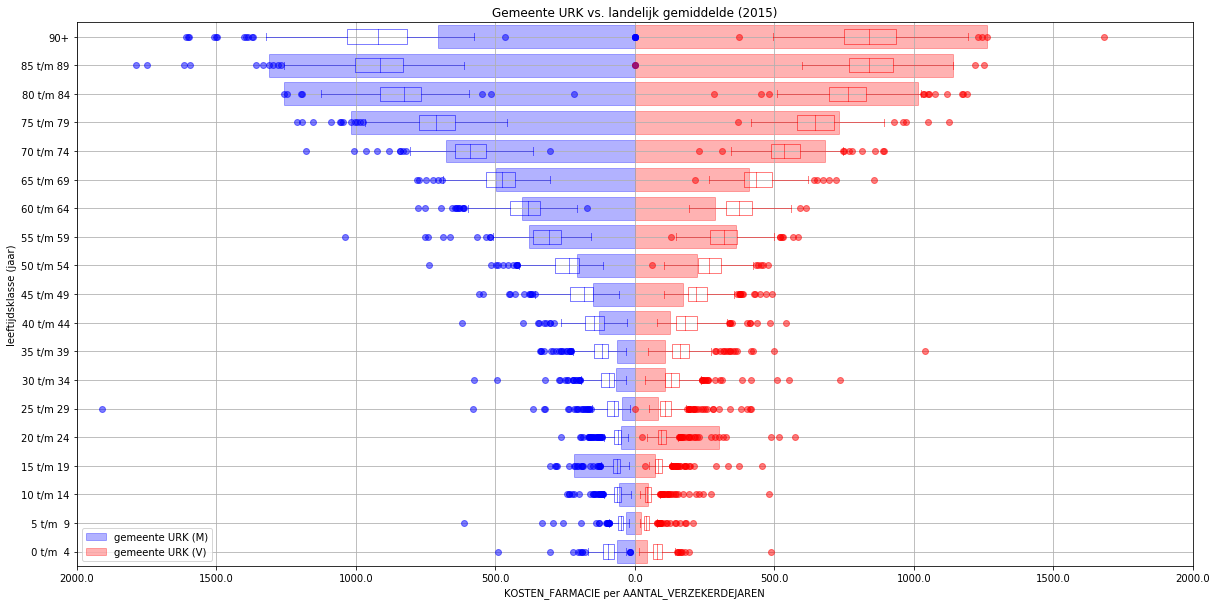

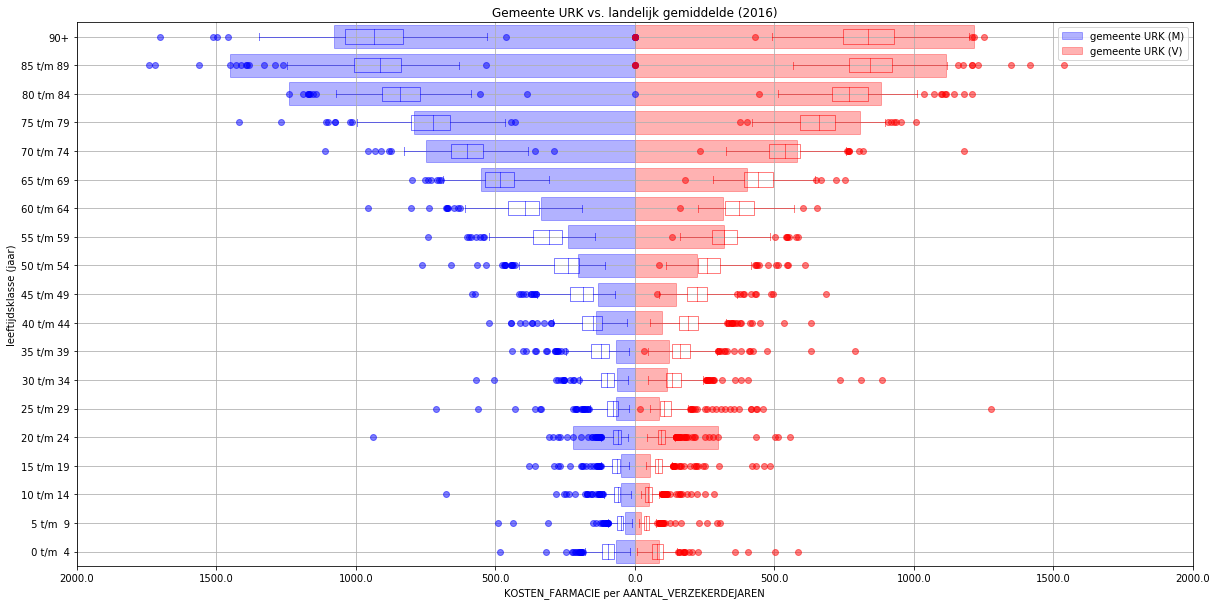

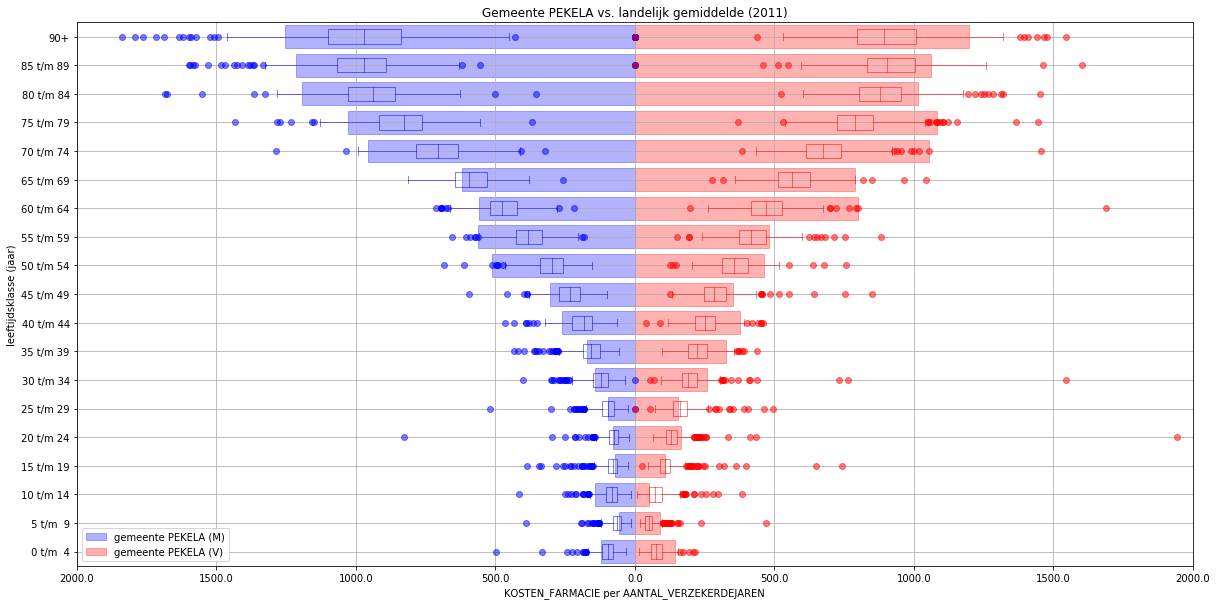

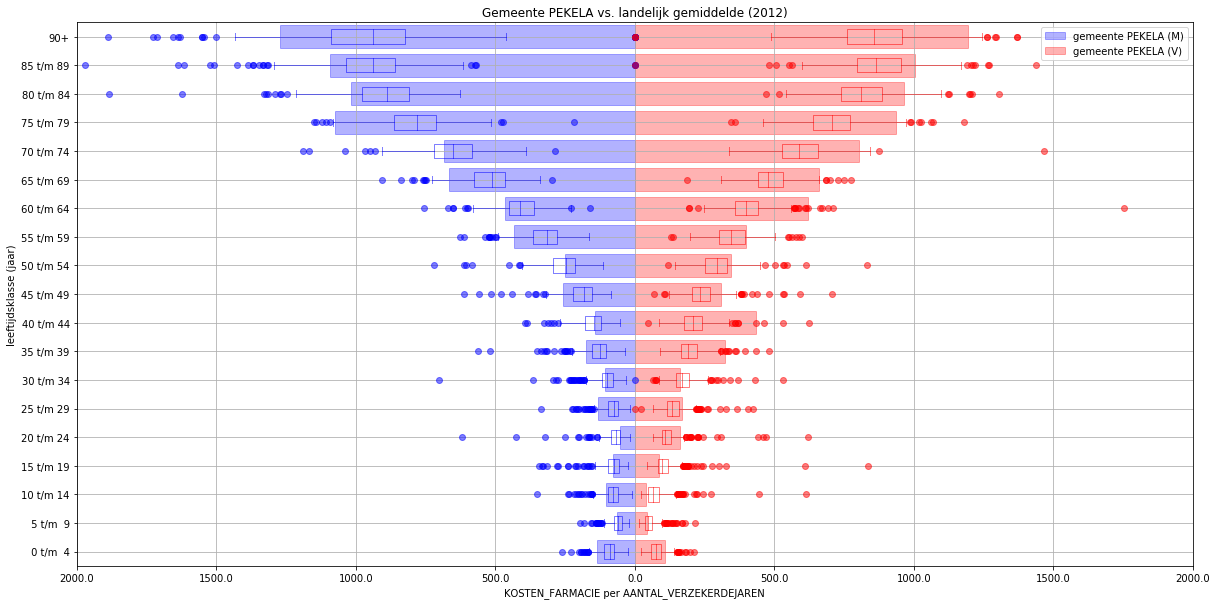

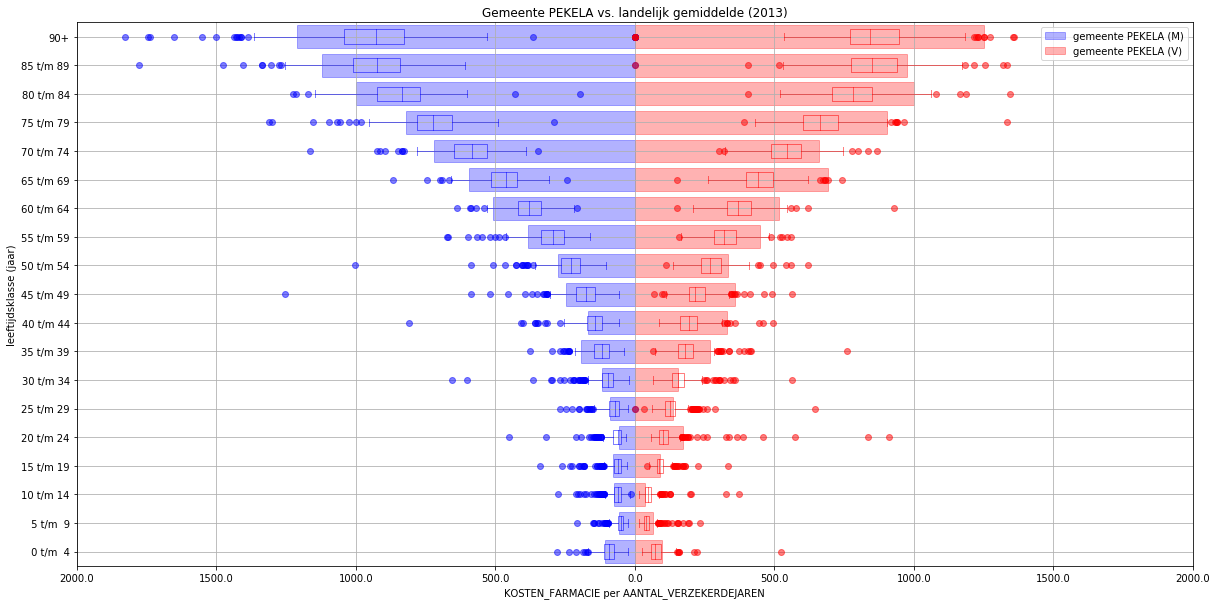

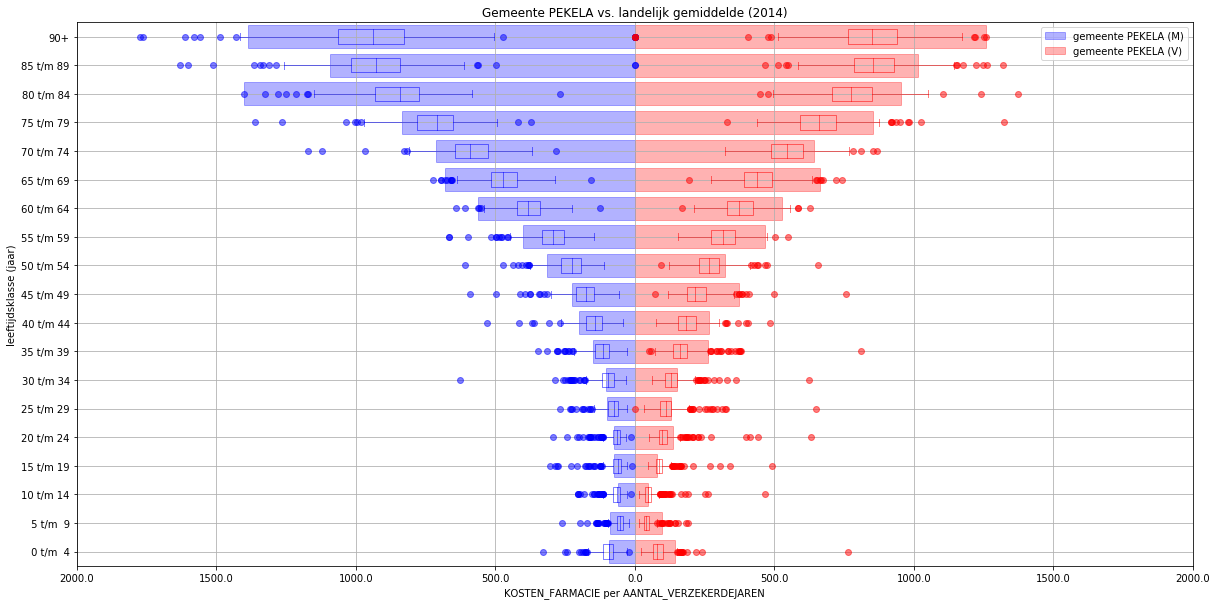

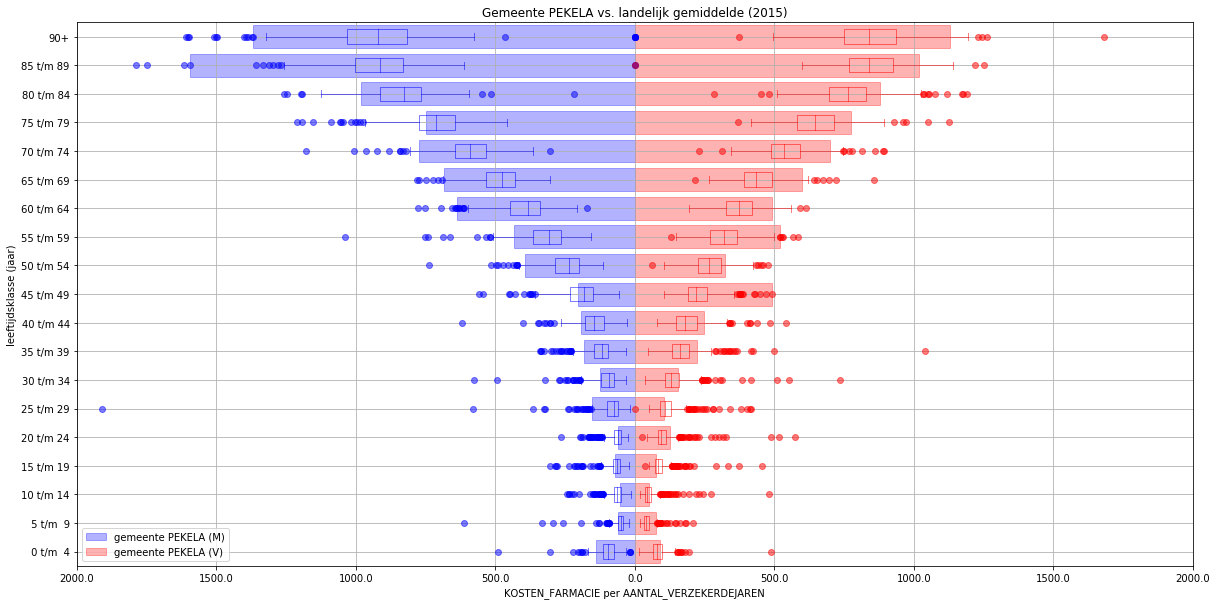

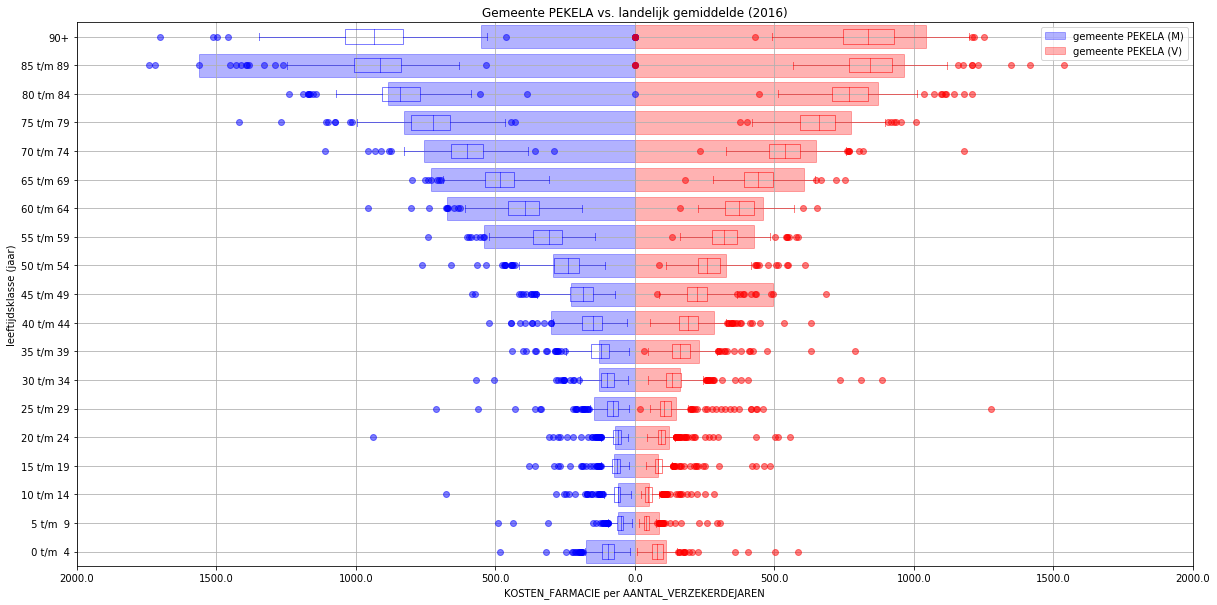

In [87]:
#Will be False after the first calculations are made, removing necessity to do the same things over and over again
firstPass = True
currentYear = ''
currentAnalysis = ''

def allInOne (yearAnalysis, municipalityAnalysis, nameAnalysis):
    global currentYear, currentAnalysis
    """Perform full analysis in one go."""
    if yearAnalysis != currentYear or nameAnalysis != currentAnalysis:
        firstPass = True
    if firstPass:
        df                         = importVektisDataMunicipalities(online, yearAnalysis, nameAnalysis, 10000)
        df_boxplot_m, df_boxplot_v = prepareBoxplotData(df, analysenaam)
        df_countryAverage          = calculateCountryAveragePerMunicipality(df, nameAnalysis)
        #plotSpreads(df_analysis3[analysekolom], analysenaam)
        df_percentiles             = calculatePercentilesPerGenderandAgeCategory(df, nameAnalysis)
        
        currentYear = yearAnalysis
        currentAnalysis = nameAnalysis
        analysekolom = nameAnalysis + ' per AANTAL_VERZEKERDEJAREN'
        firstPass = False
    
    df_municipality = processMunicipality(df, municipalityAnalysis, nameAnalysis)
    plotPopulationPyramid(df_municipality, df_boxplot_m, df_boxplot_v, df_percentiles, municipalityAnalysis, nameAnalysis, yearAnalysis)
    
    if export:
        df_municipality.to_csv('data/df_vektis_demography_' + analysejaar + '_' + analysegemeente + '.csv', decimal=',', index=True)
        df_countryAverage.to_csv('data/df_vektis_' + analysejaar + '.csv', decimal=',', index=True)
        df_countryAverage[ df_countryAverage[analysekolom] < p2_5 ].append(df_countryAverage[ df_countryAverage[analysekolom] > p97_5 ]).reset_index().to_csv('data/outliers_' + analysejaar + '.csv', decimal=',', index=False)
        df_percentiles.to_csv('data/df_vektis_percentiles' + analysejaar + '.csv', decimal=',', index=True)

if True:
    allInOne('2011','URK','KOSTEN_FARMACIE')
    allInOne('2012','URK','KOSTEN_FARMACIE')
    allInOne('2013','URK','KOSTEN_FARMACIE')
    allInOne('2014','URK','KOSTEN_FARMACIE')
    allInOne('2015','URK','KOSTEN_FARMACIE')
    allInOne('2016','URK','KOSTEN_FARMACIE')

    allInOne('2011','PEKELA','KOSTEN_FARMACIE')
    allInOne('2012','PEKELA','KOSTEN_FARMACIE')
    allInOne('2013','PEKELA','KOSTEN_FARMACIE')
    allInOne('2014','PEKELA','KOSTEN_FARMACIE')
    allInOne('2015','PEKELA','KOSTEN_FARMACIE')
    allInOne('2016','PEKELA','KOSTEN_FARMACIE')